In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pypianoroll
import random

import tensorflow.keras as keras
import tensorflow as tf
import midi
import datetime


In [2]:
y = np.load('pypianorollSamples.npy')

In [3]:
y = y[:50]

In [4]:
PCTG_ERASED = 0.1
music = y.reshape(len(y)*4, 512,72)
erased_music = np.zeros(music.shape)
mask = np.zeros(music.shape)

for i in range(len(music)):
    erased_music[i], mask[i] = midi.erase_notes(music[i], PCTG_ERASED, 72)

In [5]:
input_data = np.stack([erased_music, mask], axis=3).swapaxes(2,1)

In [ ]:
# _, rows, cols, _ = input_data.shape
# model = keras.models.Sequential([
#     keras.layers.Conv2D(36, 3, padding="same", input_shape=(rows, cols, 2)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv2D(18, 3, padding="same", input_shape=(rows, cols, 2)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same"),
#     keras.layers.Reshape((rows, cols))
# ])
_, rows, cols, _ = input_data.shape
model = keras.models.Sequential([
    keras.layers.Conv2D(1, 5, padding="same", input_shape=(rows, cols, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(10, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(20, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(40, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(20, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(10, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same"),
    keras.layers.Reshape((rows, cols))
])

In [ ]:
log_dir = os.path.join(
    "logs",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
]

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam")

history = model.fit(input_data, music.swapaxes(2,1), epochs=100, callbacks=callbacks, batch_size= 32)

plt.plot(history.history['loss'])

In [9]:
def make_music_iteration(fake_input):
    new_music = model(fake_input)
    rand_vals = np.random.uniform(size=new_music.shape)
    new_music = new_music > rand_vals
    new_music = new_music.numpy().astype('float')
    return new_music

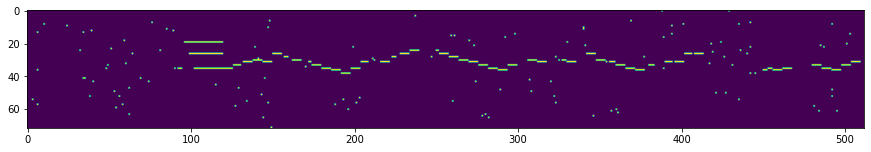

In [23]:
new_music = input_data[0,:,:,0].copy()
fake_input_music, fake_input_mask = midi.erase_notes(new_music.swapaxes(0,1), PCTG_ERASED,72)
fake_input = np.stack([fake_input_music , fake_input_mask], axis=2)
new_music = make_music_iteration(np.expand_dims(fake_input.swapaxes(0,1), axis=0))

# for i in range(1):
#     plt.figure(figsize=(15,12))
#     plt.imshow(new_music[0, :, i*512:i*512 + 512])
plt.figure(figsize=(15,12))
plt.imshow(new_music[0, :, :])


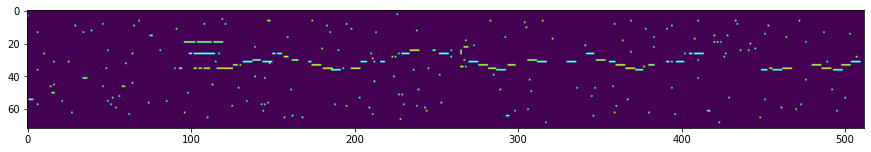

In [25]:
for _ in range(4):
    fake_input_music, fake_input_mask = midi.erase_notes(new_music[0].swapaxes(0,1), PCTG_ERASED,72)
    fake_input = np.stack([fake_input_music , fake_input_mask], axis=2)
    new_music = make_music_iteration(np.expand_dims(fake_input.swapaxes(0,1), axis=0))
    
# for i in range(4):
    # plt.figure(figsize=(15,12))
    # plt.imshow(new_music[0, :, i*512:i*512 + 512])
plt.figure(figsize=(15,12))
plt.imshow(new_music[0, :, :])

In [26]:
midi.sample2midi('teste.mid', new_music.swapaxes(1,2), 8)